It's Sunday morning, it's quiet and you wake up with a big smile on your face. Today is going to be a great day! Except, your phone rings, rather "internationally". You pick it up slowly and hear something really bizarre - "Bonjour, je suis Michele. Oops, sorry. I am Michele, your personal bank agent.". What could possibly be so urgent for someone from Switzerland to call you at this hour? "Did you authorize a transaction for $3,358.65 for 100 copies of Diablo 3?" Immediately, you start thinking of ways to explain why you did that to your loved one. "No, I didn't !?". Michele's answer is quick and to the point - "Thank you, we're on it". Whew, that was close! But how did Michele knew that this transaction was suspicious? After all, you did order 10 new smartphones from that same bank account, last week - Michele didn't call then.

Probably you feel very lucky if you are a fraud. About every 12 cents per $100 were stolen in the US during the same year. Our friend Michele might have a serious problem to solve here.

In this part of the series, we will train an Autoencoder Neural Network (implemented in Keras) in unsupervised (or semi-supervised) fashion for Anomaly Detection in credit card transaction data. The trained model will be evaluated on pre-labeled and anonymized dataset.

# Set up

We will be using TensorFlow 1.2 and Keras 2.0.4. Let's begin:


In [19]:
import pandas as pd
import numpy as np
import pickle

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 30
LABELS = ["Normal", "Fraud"]


# 1.Nhập dữu liệu

The dataset we're going to use can be downloaded from Kaggle. It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

Tập dữ liệu chúng tôi sẽ sử dụng có thể được tải xuống từ Kaggle. Nó chứa dữ liệu về các giao dịch thẻ tín dụng xảy ra trong khoảng thời gian hai ngày, với 492 gian lận trong tổng số 284.807 giao dịch.

Tất cả các biến trong tập dữ liệu là số. Dữ liệu đã được chuyển đổi bằng cách sử dụng (các) chuyển đổi PCA vì lý do bảo mật. Hai tính năng không được thay đổi là Thời gian và Số tiền. Thời gian bao gồm số giây trôi qua giữa mỗi giao dịch và giao dịch đầu tiên trong tập dữ liệu.

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!ls "/content/drive/MyDrive/creditcard.csv"

/content/drive/MyDrive/creditcard.csv


In [22]:
df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")

# 2 .Phân tích, trực quan hóa dữ liệu

In [23]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [24]:
# kích thước tập dữ liệu
df.shape

(284807, 31)

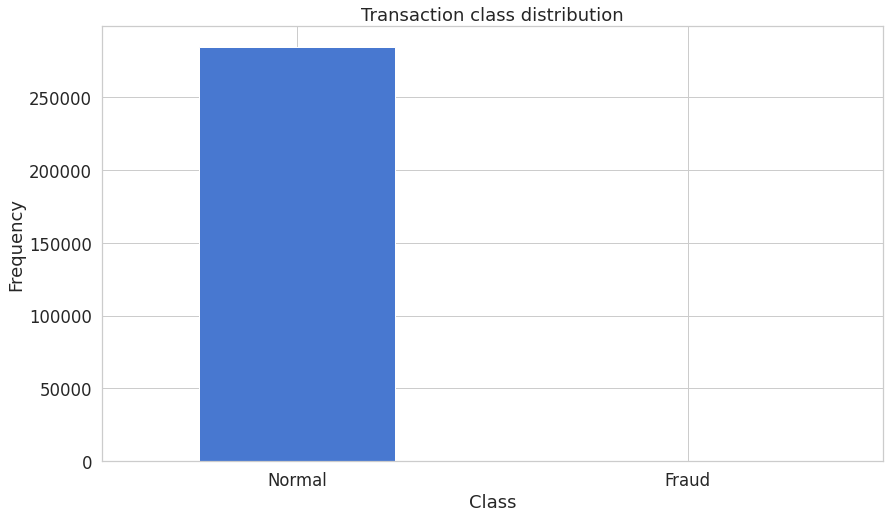

In [25]:
# Biểu đồ thể hiện số giao dịch hợp lệ (Normal) và ko hợp hệ (Fraud)
df.isnull().values.any()
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2),( "Normal","Fraud"))
plt.xlabel("Class")
plt.ylabel("Frequency");

Nhìn vào biểu đồ ta có thể nhận ra rằng đây là một tập dữ liệu rarasrt mát cân bằng. Các giao dịch thông thường áp đảo các giao dịch gian lận. ( Đây phản ảnh rằng thực tế đa phần các giao dịch là bình thường nhưng vẫn có các giao dịch không hợp lệ và không thể xem thường)

Tiếp theo là thể các giao dịch Normal và fraud bằng số:




In [26]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [27]:
# số các giao dịch không hợp lệ
frauds.shape


(492, 31)

In [28]:
# Xem xét các bản ghi giao dịch không hợp lệ
frauds

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,-0.414575,-0.503141,0.676502,-1.692029,2.000635,0.666780,0.599717,1.725321,0.283345,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,2.032912,-6.560124,0.022937,-1.470102,-0.698826,-2.282194,-4.781831,-2.615665,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,4.895844,-10.912819,0.184372,-6.771097,-0.007326,-7.358083,-12.598419,-5.131549,0.308334,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,2.101344,-4.609628,1.464378,-6.079337,-0.339237,2.581851,6.739384,3.042493,-2.721853,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,-5.587794,2.115795,-5.417424,-1.235123,-6.665177,0.401701,-2.897825,-4.570529,-1.315147,0.391167,1.252967,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,2.858466,-3.096915,-0.792532,-5.210141,-0.613803,-2.155297,-3.267116,-0.688505,0.737657,0.226138,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,1.794969,-2.775022,-0.418950,-4.057162,-0.712616,-1.603015,-5.035326,-0.507000,0.266272,0.247968,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,-5.245984,1.933520,-5.030465,-1.127455,-6.416628,0.141237,-2.549498,-4.614717,-1.478138,-0.035480,0.306271,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


In [29]:
# Tổng số các bản ghi bình thường
normal.shape


(284315, 31)

Tiếp theo ta sẽ xem xét sự khác nhau giữa số tiền giao dịch(***Amount***) giữa các giao dịch bình thường (***Normal***) và các giao dịch không hợp lệ (***Fraud***)

In [30]:
# Số tiền giao dịch trong các giao dịch không hợp lệ
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [31]:
#Số tiền giao dịch trong các giao dịch hợp lệ
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Để nhìn được rõ hơn thì ta cùng xem qua biểu đồ trực quan hóa :

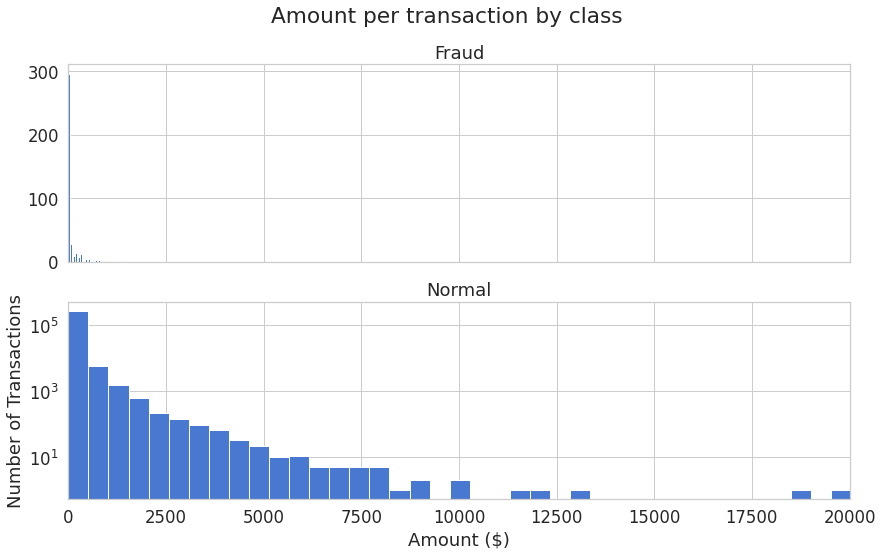

In [32]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Bây giờ ta sẽ xem xét thời gian diễn ra giao dịch có ảnh hưởng đến việc giao dịch đó có là bình thường (***Normal***) hay không bình thường (***Fraud***) không ?


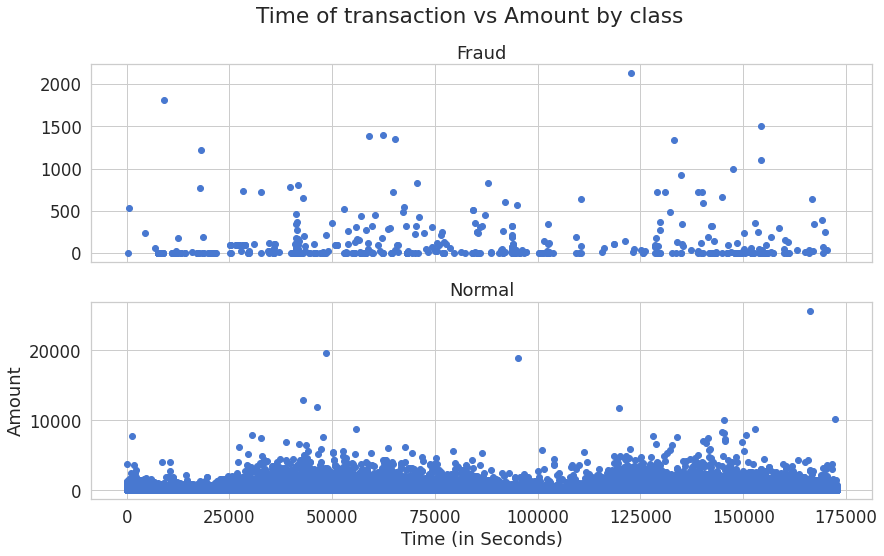

In [33]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

Sau khi xem xét qua biểu đồ ta có thể nhận thấy rằng có vẻ như là thời gian(***Time***) thực sự không ảnh hưởng nhiều đến đầu ra

# 3 Chuẩn bị dữ liệu

#### 3.1: Loại bỏ các thuộc tính không sử dụng trong mô hình

Như ta xem xét ở trên vì nhận ra rằng thuộc tính thời gian(***Time***) không ảnh hưởng đến đầu ra nên sẽ quyết định bỏ cột thời gian ra. 

In [34]:
# Xóa bỏ thuộc tính Time trong tập dữ liệu
data = df.drop(['Time'], axis=1)



### 3.2: Chuẩn hóa dữ liệu
Và ta cũng được biết là dữ liệu đã được xử lý nên bây giờ ta cũng sẽ thược hiện chuẩn hóa dữ liệu của cột tổng tiền (***Amount***) bằng hàm  [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) trong khoảng (-1,1)

In [35]:
#Chuẩn hóa dữ liệu Amount trong khoảng [-1:1]
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [36]:
# tập dữ liệu sau khi được xử lý
print(data.shape)
data.head()

(284807, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


### 3.3: Phân chia tập train, test
Bây giờ ta sẽ thực hiện phân chia tập train và tập test ở đây tôi sẽ sử dụng hàm * [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)* có sẵn của thư viện Sklearn để phân chia theo tỉ lệ là 8:2 ( **80%** cho tập train và **20%** cho tập test)

In [37]:
X = data.iloc[:, 0:30]
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)




In [38]:
# Xem xét tập dữ liệu train
print(X_train.shape)
X_train.head()

(227845, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
223361,1.955041,-0.380783,-0.315013,0.330155,-0.509374,-0.086197,-0.627978,0.035994,1.054560,-0.030441,0.624996,1.691496,1.255790,-0.253266,-0.331695,0.307252,-0.930844,0.651666,0.167987,-0.125390,0.238197,0.968305,0.053208,-0.278602,-0.044999,-0.216780,0.045168,-0.047145,-0.313289,0
165061,-0.400975,-0.626943,1.555339,-2.017772,-0.107769,0.168310,0.017959,-0.401619,0.040378,0.611115,-1.945070,-0.726597,1.060888,-1.193347,0.631053,-0.160123,-1.630444,2.106866,-1.692780,-0.470372,-0.153485,0.421703,0.113442,-1.004095,-1.176695,0.361924,-0.370469,-0.144792,-0.169717,0
238186,0.072509,0.820566,-0.561351,-0.709897,1.080399,-0.359429,0.787858,0.117276,-0.131275,-0.638222,0.521931,-0.072768,-1.008237,-0.640249,-0.801946,0.678131,0.044374,0.521919,0.198772,0.012227,-0.314638,-0.872959,0.083391,0.148178,-0.431459,0.119690,0.206395,0.070288,-0.305292,0
150562,-0.535045,1.014587,1.750679,2.769390,0.500089,1.002270,0.847902,-0.081323,0.371579,0.560595,-0.855437,-4.179628,0.286872,1.271254,-1.011647,1.458600,-0.613260,0.814931,-2.147124,-0.253757,0.063525,0.443431,-0.072754,0.448192,-0.655203,-0.181038,-0.093013,-0.064931,0.116306,0
138452,-4.026938,1.897371,-0.429786,-0.029571,-0.855751,-0.480406,-0.435632,1.313760,0.536044,1.221746,0.472626,1.595929,0.777603,0.187685,-1.060579,0.143332,0.007803,-0.055817,0.712695,-0.012320,-0.480691,-0.230369,0.250717,0.066399,0.470787,0.245335,0.286904,-0.322672,-0.250239,0


In [39]:
print(y_train.shape)
# y_train

(227845,)


In [40]:
# Xem xét tập dữ liệu test
print(X_test.shape)
X_test.head()

(56962, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
43428,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,-14.110184,5.299236,-10.834006,1.671120,-9.373859,0.360806,-9.899247,-19.236292,-8.398552,3.101735,-1.514923,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,1.102834,1
49906,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,-0.565012,-0.087670,0.979427,0.076883,-0.217884,-0.136830,-2.142892,0.126956,1.752662,0.432546,0.506044,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,1.726255,0
29474,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,0.756801,0.543827,0.112453,1.075384,-0.245772,0.180483,1.769860,-0.533172,-0.533300,1.192245,0.212877,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,-0.229289,0
276481,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,-1.376648,-1.328335,0.223621,1.132627,-0.550875,0.616568,0.497974,0.502195,0.981343,0.101264,-0.244633,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,-0.347232,0
278846,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,0.259452,0.942162,0.850038,-0.616166,0.592634,-0.603845,0.091077,-0.471867,-0.333816,0.404711,-0.255293,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,-0.349671,0


# 4.Xây dựng model


### 4.1: Giới thiệu sơ thuật toán KNN
Bắt đầu xây dựng model ở đây tôi sẽ sử dụng thuật toán [KNN](https://vi.wikipedia.org/wiki/Gi%E1%BA%A3i_thu%E1%BA%ADt_k_h%C3%A0ng_x%C3%B3m_g%E1%BA%A7n_nh%E1%BA%A5t). 

![link text](https://codelearn.io/Upload/Blog/thuat-toan-knn-qua-vi-du-63732823036.1851.jpg)

  Thuật toán KNN là một thuật toán đơn giản trong ML. Nó được xếp vào loại Lazy learning.

  Ý tưởng của thuật toán này sẽ gán nhãn cho lớp của phần tử mới, ứng với phần đông trong số các phần tử lân cận gần nó nhất. Nhãn đó có thể được quyết định bằng bầu chọn theo đa số (major voting) trong số K điểm gần nhất, hoặc nó có thể được suy ra bằng cách đánh trọng số khác nhau cho mỗi trong các điểm gần nhất đó rồi suy ra kết quả.

  Có một câu nói rất nổi tiếng về ý tưởng của thuật toán này là :  
" Tell me who your friends are, and I will tell you who you are. "  
( Hãy cho tôi biết về những người bạn của bạn, tôi sẽ cho bạn biết bạn là ai. )

### 4.2: Chạy model
Ở đây thì tôi sẽ sử dụng thư viện có sẵn của sklearn.
[Các thông số của KNeighborsClassifier](https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [41]:
#Gọi package sklearn
from sklearn.neighbors import KNeighborsClassifier
#Khởi tạo biến knn sử dụng thuật toán phân lớp KNN, với n = 3
knn = KNeighborsClassifier(algorithm='ball_tree',n_neighbors = 3,metric='euclidean')

In [42]:
#Huấn luyện mô hình với tập dữ liệu train:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

### 4.3: Kết quả

In [72]:
# khởi tạo biên dự đoán
y_pred = knn.predict(X_test)

In [73]:
#Hiện thị dự doán ở dòng 5000-6000
y_pred[5000:6000]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [74]:
print(type(y_pred))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


# 5.Đánh giá mô hình

In [75]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[56861     3]
 [   21    77]]


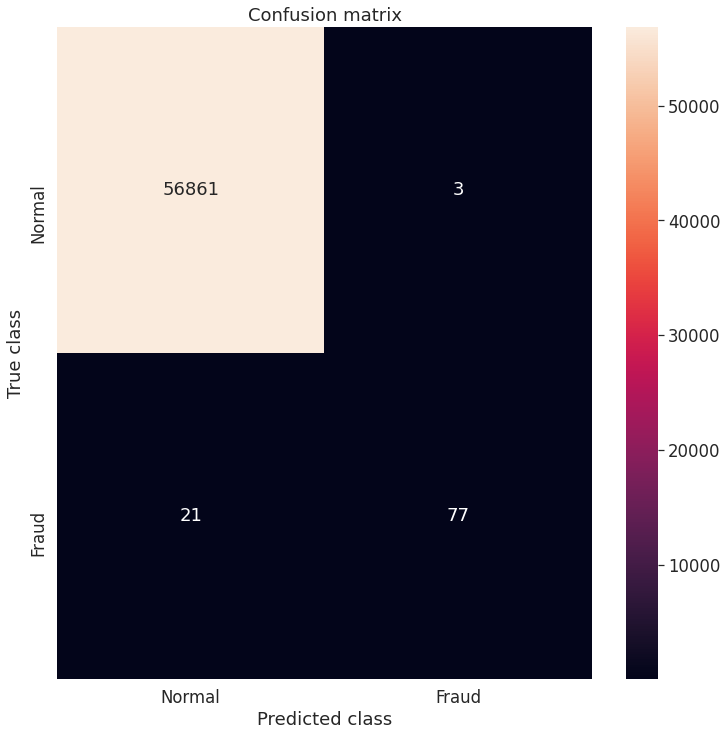

In [76]:
# trực quan hóa .
plt.figure(figsize=(12, 12))
sns.heatmap(cm, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [77]:
print(f1_score(y_test, y_pred))

0.8651685393258427


In [99]:
# Độ chính xác của mô hình
acc_knn =accuracy_score(y_test, y_pred)*100
print("Độ chính xác của mô hình là: ",acc_knn,"%")

Độ chính xác của mô hình là:  99.95786664794073 %


# 6.So sánh với các thuật toán khác:

### 6.1:SVC ( Suport Vector Machine)

In [79]:
from sklearn.svm import SVC

svc = SVC(gamma='auto')

#Huấn luyện mô hình với dữ liệu Train:
svc.fit(X_train, y_train)

#Xác định độ chính xác của mô hình trên tập Train:
acc_svc = round(svc.score(X_train, y_train) * 100, 2)

print("Độ chính xác của mô hình SVC trên tập Train: ", acc_svc, "%")
print("Các tham số của model SVM:\n",svc)

Độ chính xác của mô hình SVC trên tập Train:  99.98 %
Các tham số của model SVM:
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [80]:
# khởi tạo biên dự đoán
y_pred_2 = svc.predict(X_test)

In [81]:
cm = confusion_matrix(y_test, y_pred_2)
print(cm)

[[56862     2]
 [   29    69]]


In [95]:
acc_svc = accuracy_score(y_test, y_pred_2)*100
# Độ chính xác của mô hình
print("Độ chính xác của mô hình là: ",acc_svc,"%")

Độ chính xác của mô hình là:  99.94557775359011 %


### 6.2: Decision tree

In [83]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(criterion='entropy')
decision_tree.fit(X_train, y_train)

acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)

print("Độ chính xác của mô hình NB trên tập Train: ", acc_decision_tree, "%")
print("Các tham số của Model Decision Tree: \n", decision_tree)

Độ chính xác của mô hình NB trên tập Train:  100.0 %
Các tham số của Model Decision Tree: 
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [84]:
# khởi tạo biên dự đoán
y_pred_1 = decision_tree.predict(X_test)

In [85]:
cm = confusion_matrix(y_test, y_pred_1)
print(cm)

[[56864     0]
 [    0    98]]


In [ ]:
# trực quan hóa .
plt.figure(figsize=(12, 12))
sns.heatmap(cm, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [97]:
# Độ chính xác của mô hình
acc_Dtree = accuracy_score(y_test, y_pred_1)*100
print("Độ chính xác của mô hình là: ",acc_Dtree,"%")

Độ chính xác của mô hình là:  100.0 %


### 6.3:Model Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
#Huấn luyện mô hình với tập Train
logreg.fit(X_train,y_train)

#Độ tin cậy của mô hình (Tính trên tập Train)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
print("Độ chính xác của mô hình LoR trên tập Train: ", acc_log, "%")
print("Các tham số của Model LogisticRegression: \n",logreg)

Độ chính xác của mô hình LoR trên tập Train:  100.0 %
Các tham số của Model LogisticRegression: 
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [89]:
# khởi tạo biên dự đoán
y_pred_3 = decision_tree.predict(X_test)

In [90]:
cm = confusion_matrix(y_test, y_pred_3)
print(cm)

[[56864     0]
 [    0    98]]


In [98]:
# Độ chính xác của mô hình
acc_logr = accuracy_score(y_test, y_pred_3)*100
print("Độ chính xác của mô hình là: ",acc_logr,"%")

Độ chính xác của mô hình là:  100.0 %


In [102]:
#thống kê độ chính xác của các Model:
#Tạo một DataFrame lưu trữ tên model và độ chính xác của model, sắp xếp theo thứ tự giảm dần của độ chính xác
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression','Decision Tree'],
    'Score (%)': [acc_svc, acc_knn, acc_Dtree,acc_logr],
    'Parameter':[svc,knn,logreg,decision_tree]})

models.sort_values(by='Score (%)', ascending=False)

,Model,Score (%),Parameter
2,Logistic Regression,100.000000,"LogisticRegression(C=1.0, class_weight=None, d..."
3,Decision Tree,100.000000,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
1,KNN,99.957867,"KNeighborsClassifier(algorithm='ball_tree', le..."
0,Support Vector Machines,99.945578,"SVC(C=1.0, break_ties=False, cache_size=200, c..."
